# Extracting Catalogue Entries from the Transcribed Text of a Catalogue  

This notebook is the material for the first half of the Catalogues as Data for Computational Analysis Workshop at DHNB 2024.

The British Library holds over 12,500 [Incunabula](https://data.cerl.org/istc/_search) (books with movable type printed pre-1501). The British Museum Catalogue (BMC) is the printed catalogue of these works. There are 13 volumes of the catalogue, published between 1908 and 2007, 10 volumes have been digitised and processed using an Optical Character Recognition (OCR) software called [Transkribus](https://www.transkribus.org/). We'll look at extracting catalogue entries from volumes 1 (Block books and some parts of Germany), 8 (France) and 10 (Spain) of the BMC in the first half of the workshop. The catalogue entries were used in corpus linguistic analysis (the second half of this workshop), as well as to enrich existing entries for the works in our main catalogue with copy specific information.

##### This notebook demonstrates how we extracted catalogue entries from the OCR'd text.
We'll go through the following steps to learn how it works:
1. Use our algorithm to extract catalogue entries from the xml outputs of the OCR process and discuss how accurate it is
2. Go through the steps of the algorithm to understand how it works
3. Once we understand how it works we will consider ways to improve accuracy and add functionality
4. Finally we will look at simple Named Entity Recognition to enrich transcription results.

##### By the end of this part of the workshop you should be able to:
- explain the steps involved in (one method of) processing transcribed text
- understand how to build an algorithm to extract structured catalogue entries from unstructured data
- use a Jupyter notebook and read some Python.

### Jupyter notebook 30 second crash course
This is a JupyterLab version of a Jupyter notebook. A notebook is a collection of text and code that makes it easy to run code interactively, and present it neatly with text and images. The notebook is running on a service called Binder which makes it easy to share notebooks. 

Here is a very brief introduction to how to use them:  
The grey region with 'import' statements in it below is called a 'cell'.
  
Blue bar to the left of the cell = active cell.  
White active cell background = editing.  
Grey active cell background = not editing.  
Click a cell or hit enter to edit.  
Esc to stop editing.

Shift + enter to run a cell and go to the next cell.  
Ctrl + enter to run a cell (without going to the next one).  
Can also click the 'run' icon in the toolbar at the top.  
The cell has a little asterisk next to it when running, which will turn into a number when finished

Arrows keys (when cell has grey background)/scroll to move up and down

Congratulations you're an expert! Hit H when in command mode to get the full list of keyboard shortcuts

In [ ]:
# This cell contains Python, we'll need all the 'packages' imported in this cell to run the rest of the code in the notebook
# Click this cell and do Ctrl + Enter or Shift + Enter

import sys
if '../' not in sys.path:
    sys.path.append('../')
import os
import pandas as pd
import spacy
from src.data import xml_extraction as xmle
from src.data.reimport_utils import converters
from src.visualise.entry import gen_page_entries_lookup, display_entry, display_page

## Extracting catalogue entries from page xmls

Optical character recognition (OCR) was run on Transkribus. Below are two pages from Volume 1 of the BMC - covering block books and parts of Germany. Take a look at the Transkribus site for the [left](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/8) and [right](https://app.transkribus.org/sites/BL-Incunabula/doc/2102499/detail/5) pages to see what they look like with transcribed text overlaid. The left page is a '2 column' page, and the right is a '4 column' page, with full width text ("Printer of the Catholicon...") in between the entries at the top and bottom of the page. Different layout models were required to transcribe these different layouts. 

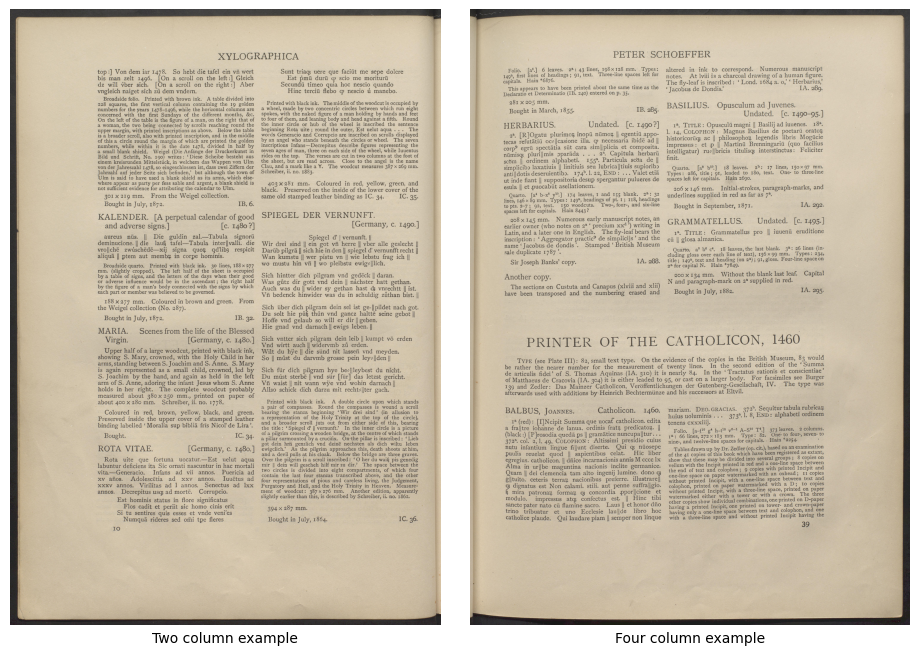

The output of transcription is an xml file for each image. For this workshop we're using the first 15 pages of volumes 1 (Block books/German), 8 (French) and 10 (Spanish). Run the code below to extract catalogue entries from the XMLs for each volume so we can have a look at the results.

In [ ]:
for i in [1, 8, 10]:  # iterate over volumes 1, 8, and 10
    print(f"**Volume {i}**\n")
    two_col_loc = f"../data/raw/BMC_{i}_2/*/*.pxml"
    four_col_loc = f"../data/raw/BMC_{i}_4/*/*.pxml"
    xmls_2, xmls_4 = xmle.gen_xml_paths(two_col_loc), xmle.gen_xml_paths(four_col_loc)
    print(f"{len(xmls_2) + len(xmls_4)} xmls extracted from\n"
          f"2 col ({len(xmls_2):03}): {os.path.dirname(xmls_2[0])}\n"
          f"4 col ({len(xmls_4):03}): {os.path.dirname(xmls_4[0])}")
    vol_xml_trees = xmle.gen_xml_trees(xmls_2 + xmls_4)

    print("\nExtracting catalogue entries from xmls")
    lines, xml_track_df = xmle.extract_lines_for_vol(vol_xml_trees)
    title_shelfmarks, title_indices, ordered_lines = xmle.find_headings(lines)
    entry_df = xmle.extract_catalogue_entries(ordered_lines, title_indices, title_shelfmarks, xml_track_df)
    print(f"Extracted {len(entry_df)} entries")

    out_path = f"../data/processed/BMC_{i}"
    print(f"Saving catalogue entries to {out_path}\n")
    if not os.path.exists(out_path):
        os.makedirs(out_path)
        
    entry_df.to_csv(os.path.join(out_path, "catalogue_entries.csv"))

## Visualise extracted catalogue entries

The code above produces csv files with catalogue entries for each volume in the data/processed folder. We can visualise these results on the pages they were extracted from:

In [ ]:
# run this cell to load extracted entries into memory
german_entries = pd.read_csv("../data/processed/BMC_1/catalogue_entries.csv", converters=converters, index_col=0)
german_pages = gen_page_entries_lookup(german_entries).set_index(pd.RangeIndex(1,16))
french_entries = pd.read_csv("../data/processed/BMC_8/catalogue_entries.csv", converters=converters, index_col=0)
french_pages = gen_page_entries_lookup(french_entries).set_index(pd.RangeIndex(2,16))
french_pages.loc[1] = ["J_2704_aa_30_8_0098_4", [[]], 0]
french_pages.sort_index(inplace=True)
spanish_entries = pd.read_csv("../data/processed/BMC_10/catalogue_entries.csv", converters=converters, index_col=0)
spanish_pages = gen_page_entries_lookup(spanish_entries).set_index(pd.RangeIndex(1,16))

vols = {
    "german":{"pages": german_pages, "entries": german_entries},
    "french":{"pages": french_pages, "entries": french_entries},
    "spanish":{"pages": spanish_pages, "entries": spanish_entries}}

### Transkribus links

Vol 1: German  
Page
[1](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/1), 
[2](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/2),
[3](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/3),
[4](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/4),
[5](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/5),
[6](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/6),
[7](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/7),
[8](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/8),
[9](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/9),
[10](https://app.transkribus.org/sites/BL-Incunabula/doc/2102499/detail/1),
[11](https://app.transkribus.org/sites/BL-Incunabula/doc/2102499/detail/2),
[12](https://app.transkribus.org/sites/BL-Incunabula/doc/2102499/detail/3),
[13](https://app.transkribus.org/sites/BL-Incunabula/doc/2102499/detail/4),
[14](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/10),
[15](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/11)  
Vol 8: French  
Page
[1](https://app.transkribus.org/sites/BL-Incunabula/doc/2102619/detail/1), 
[2](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/1),
[3](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/2),
[4](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/3),
[5](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/4),
[6](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/5),
[7](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/6),
[8](https://app.transkribus.org/sites/BL-Incunabula/doc/2102619/detail/2),
[9](https://app.transkribus.org/sites/BL-Incunabula/doc/2102619/detail/3),
[10](https://app.transkribus.org/sites/BL-Incunabula/doc/2102619/detail/4),
[11](https://app.transkribus.org/sites/BL-Incunabula/doc/2102619/detail/5),
[12](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/7),
[13](https://app.transkribus.org/sites/BL-Incunabula/doc/2102619/detail/6),
[14](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/8),
[15](https://app.transkribus.org/sites/BL-Incunabula/doc/2102620/detail/9)  
Vol 10: Spanish  
Page
[1](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/1), 
[2](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/2),
[3](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/3),
[4](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/4),
[5](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/5),
[6](https://app.transkribus.org/sites/BL-Incunabula/doc/2102559/detail/1),
[7](https://app.transkribus.org/sites/BL-Incunabula/doc/2102559/detail/2),
[8](https://app.transkribus.org/sites/BL-Incunabula/doc/2102559/detail/3),
[9](https://app.transkribus.org/sites/BL-Incunabula/doc/2102559/detail/4),
[10](https://app.transkribus.org/sites/BL-Incunabula/doc/2102559/detail/5),
[11](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/6),
[12](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/7),
[13](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/8),
[14](https://app.transkribus.org/sites/BL-Incunabula/doc/2102579/detail/9),
[15](https://app.transkribus.org/sites/BL-Incunabula/doc/2102559/detail/6)

### Exercise: How Accurate is the Algorithm
We'll start with the first volume of block books and works printed in parts of Germany. Work through the pages looking at the extracted entries.
- Spend a few minutes looking at the extracted entries, then discuss with the person next to you where have the entries been extracted well and badly.
- There are errors in the extracted entries, why do you think these errors might have occured?
- You can use the links to Transkribus to check how the text for each page has been transcribed. 

In [ ]:
# replace with "french" or "spanish" to see the other volumes
lang = "german"

In [ ]:
# Choose a page to view by editing the page variable on the next line
page = 1

if page < 1 or page > 15:
    raise ValueError("Please choose a page between 1 - 15")

page_view = display_page(page, vols[lang]["pages"])

In [ ]:
# Alternatively choose an invidual catalogue entry to view
# There are 48 German, 56 French, and 43 Spanish entries
entry = 1

entry_view = display_entry(vols[lang]["entries"].loc[entry - 1])

## Understanding entry extraction

Now we've looked at some of the extracted entries let's go back and understand how we extracted them. Here's the code again:

```python
for i in [1, 8, 10]:  # iterate over volumes 1, 8, and 10
    print(f"**Volume {i}**\n")
    two_col_loc = f"../data/raw/BMC_{i}_2/*/*.pxml"
    four_col_loc = f"../data/raw/BMC_{i}_4/*/*.pxml"
    xmls_2, xmls_4 = xmle.gen_xml_paths(two_col_loc), xmle.gen_xml_paths(four_col_loc)
    print(f"{len(xmls_2) + len(xmls_4)} xmls extracted from\n"
          f"2 col ({len(xmls_2):03}): {os.path.dirname(xmls_2[0])}\n"
          f"4 col ({len(xmls_4):03}): {os.path.dirname(xmls_4[0])}")
    vol_xml_trees = xmle.gen_xml_trees(xmls_2 + xmls_4)
    
    print("\nExtracting catalogue entries from xmls")
    lines, xml_track_df = xmle.extract_lines_for_vol(vol_xml_trees)
    title_shelfmarks, title_indices, ordered_lines = xmle.find_headings(lines)
    entry_df = xmle.extract_catalogue_entries(ordered_lines, title_indices, title_shelfmarks, xml_track_df)
    print(f"Extracted {len(entry_df)} entries")

    out_path = f"../data/processed/BMC_{i}"
    print(f"Saving catalogue entries to {out_path}\n")
    if not os.path.exists(out_path):
        os.makedirs(out_path)
        
    entry_df.to_csv(os.path.join(out_path, "catalogue_entries.csv"))
```
</mark>

This may seem complex but we'll ignore most of it. The line we're interested in is  
`title_shelfmarks, title_indices, ordered_lines = xmle.find_headings(lines)`  

Everything before this extracts lines of text from the xmls for a given volume and converts them to a combined list of text lines for the whole volume. `xmle.find_headings(lines)` is the algorithm we use to find catalogue entries. It works like this:
1. Iterate through the lines in the volume, looking for shelfmarks in each line using three regular expressions (patterns) that match the shelfmarks in the text.
    1. Shelfmarks in the text come at the end of catalogue entries and start with one of IA./IB./IC., C., or G. and are followed by a series of numbers and letters
    2. The first shelfmark on page 1 of volume 1 is IB. 13 (though it hasn't been correctly detected as an entry) - look back on some of the pages above and identify some of the shelfmarks
3. If a shelfmark is found, pause and check the next 7 lines.
4. If a date (or the word 'Undated') and capitalised words are found in the next 7 lines then everything after the initial shelfmark up to and including the date is considered the title of an entry
    1. If another shelfmark is found in the 7 lines then break, go back to step 1 and continue looking for shelfmarks
5. Save the entry title, then continue looking for shelfmarks

This algorithm runs over all the lines in a volume looking for titles. All the code that comes after takes the locations of entry titles and assigns the text between titles to the correct catalogue entry, and finally exports entries as a csv with information about each entry attached.

`find_headings` contains all the logic for working out where catalogue entries start and end. It does this by finding the titles at the start of entries. `extract_catalogue_entries` then pulls all the text between one entry heading and the next to form that entry.

### Exercise: Understand Entry Extraction on Vol 1, pg 1  
Follow the Transkribus link for [page 1](https://app.transkribus.org/sites/BL-Incunabula/doc/2102440/detail/1) of the German volume. Working alone or with the person next to you use the explanation of the logic of the algorithm to understand why the 'ANTICHRISTUS' (IB. 13) and 'APOCALYPTI SANTCI JOHANNIS' (IC. 40) entries haven't been correctly detected.
- Once you have an answer look at the first pages of the French and Spanish volumes, do you notice anything similar with how entries have been detected on these pages?
- Spend a few minutes looking at entries on other pages. If you find errors can you understand why they have occured? Is it related to the algorithm or to transcription? Keep referring back to Transkribus to see how the lines of text have been transcribed.

In [ ]:
page_view = display_page(1, vols["german"]["pages"])

### Discussion
- How might you go about fixing some of the issues you've uncovered?
- The code identifies minor reading order errors in Transkribus and fixes them. This produces correct catalogue entries, but leaves the errors on Transkribus. What are sensible ways to set up transcription workflows that allow errors identified in post-processing transcribed text (which is what we're doing here) to be corrected? Is this an important step in a workflow or not?

### Finding "Another Copy" information in entries

Entries often contain information about a work, then note that collection contains multiple copies of the same work. In some cases these are complete copies, in others just fragments. These separate copies mostly have their own shelfmarks and need to be catalogued separately, using the same bibliographic information but different copy specific information.  

The page below is a good example. There are "A cancelled copy of..." entries in the first column, and DURANTI at the end of the first column has "Another copy" a quarter of the way down the second column.

Copy specific information on the other copies mentioned in the BMC is missing from our main catalogue. Detecting copies within catalogue entries is therefore important so that we can enrich entries in our main online catalogue with as much copy specific information as possible. 

#### Exercise: Adding functionality to the algorithm
- How might you add to the existing algorithm, or add a second algorithm once entries have been extracted, to split out examples of another copy?

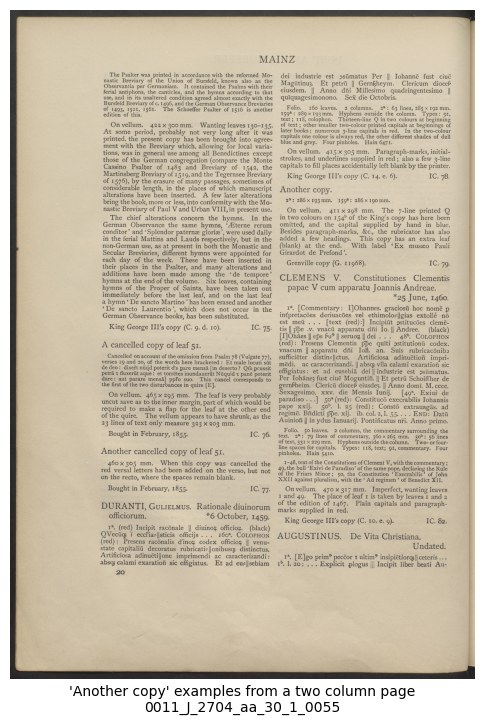

## Named Entity Recognition

This will be a brief example of running Named Entity Recognition on the extracted text. The NER model we will use is part of the Spacy package, and is trained on English text from the web. How well might you expect it to perform on catalogue volumes published over the last hundred years, and referring to works printed pre-1500? 

In [ ]:
# This cell will take a minute to run as it downloads the 12MB Natural Language Processing model we'll use for NER
# It only needs to be run once!!
!python -m spacy download en_core_web_sm

In [ ]:
# Prepare the NLP model and run it on the entries we extracted from Vol 1
nlp = spacy.load("en_core_web_sm")
german_entries["nlp"] = german_entries["entry_text"].apply(lambda x: nlp(x))

In [ ]:
# We'll look at the relatively short entry #5
ner_entry = 5
print(german_entries.loc[ner_entry - 1, "entry_text"])

Here are the named entities Spacy has extracted. GPE is geopolitical entity (i.e. location), ORG is organisation.

In [ ]:
[print(x.text.ljust(10, " "), x.label_) for x in german_entries.loc[4, "nlp"].ents if x.label_ not in ["CARDINAL", "ORDINAL"]];

### Exercise
- How well do you think this NER model has performed?
- Why do you think it has performed in this way?

In [ ]:
entry_view = display_entry(vols[lang]["entries"].loc[ner_entry - 1])

## The end

Well done for making it to the end! There's one small step to convert the csv of results into txt file format for use in AntConc, but otherwise we've covered all steps in the catalogue entry extraction process.

Thanks for taking part, and please ask any questions in the workshop or contact me on harry.lloyd@bl.uk

## Questions to take away

1. We have explicitly used regular expressions and order based logic to build this algorithm. How would it differ if we used an LLM instead?
    - What would change in the workflow?
    - Would there be a tradeoff between accuracy and explainability?
    - How do we use LLMs with transcribed (sometimes innaccurate) and historical (sometimes beyond the LLMs training data) material?

2. One of the reasons why there are errors in the entry extraction is because there are errors in the transcription. What should we do with errors detected while processing transcribed text?

3. Could you apply this method to your own unstructured text?